# INFO 213 Final Project
# Project Title: Using Textual Features to Predict Online Article Popularity
# Group Members: Claudia Adam (cca57), Anastasiia Poverenova (ap3886), Vincent So (vs634)

Dataset: Online News Popularity

https://archive.ics.uci.edu/dataset/332/online+news+popularity

# Preview Dataset
(dataset was cleaned by publishers before downloading)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving OnlineNewsPopularity.csv to OnlineNewsPopularity (1).csv


In [ ]:
df = pd.read_csv('OnlineNewsPopularity.csv')
df.columns = df.columns.str.strip()
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   url                            39644 non-null  object 
 1   timedelta                      39644 non-null  float64
 2   n_tokens_title                 39644 non-null  float64
 3   n_tokens_content               39644 non-null  float64
 4   n_unique_tokens                39644 non-null  float64
 5   n_non_stop_words               39644 non-null  float64
 6   n_non_stop_unique_tokens       39644 non-null  float64
 7   num_hrefs                      39644 non-null  float64
 8   num_self_hrefs                 39644 non-null  float64
 9   num_imgs                       39644 non-null  float64
 10  num_videos                     39644 non-null  float64
 11  average_token_length           39644 non-null  float64
 12  num_keywords                   39644 non-null 

# Logistic Regression

In [ ]:
import numpy as np, pandas as pd
from google.colab import files
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In the same online-news dataset used by the paper, I built a Logistic Regression classifier to predict article popularity. Unlike tree ensembles, LR models the log-odds of popularity as a linear function of features, passed through a sigmoid to produce probabilities. This makes it a strong, interpretable baseline and lets us see which features push popularity up or down.

In [ ]:
# this defines the target
# we call an article "popular" if its shares are greater or equal to median
median_shares = df["shares"].median()
df["popular"] = (df["shares"] >= median_shares).astype(int)

In [ ]:
# separate features and target
# so drop columns that shouldn't be used for training
drop_cols = {"url", "timedelta", "shares", "popular"}
feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols].astype(np.float32)
y = df["popular"].values

**Preprocessing**

I followed standard LR best practices.

- Removed non-predictive fields: url, timedelta, the raw shares, and the derived target.

- Created a binary target popular (1 if shares ≥ dataset median, else 0).

- Split data 80/20 with stratification to preserve class balance.

- Used a Pipeline with StandardScaler (LR assumes features are on comparable scales).

In [ ]:
# split into train (80%) and test (20%) while keeping class balance the same
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# build a pipeline
# StandardScaler: scale features so logistic regression behaves better
# LogisticRegression: the classifier itself
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        solver="liblinear",
        penalty="l2",
        max_iter=2000,
        random_state=42
    ))
])

**Building the model**

To keep training fast and reproducible, I tuned a compact grid over the regularization strength C while fixing L2 penalty and the liblinear solver. Cross-validation used StratifiedKFold(5) and F1 as the scoring metric to balance precision/recall on the slightly imbalanced classes. The search selected C = 100.0 (lighter regularization).

In [ ]:
# set the hyperparameter grid, only tune C
# smaller C = stronger regularization, larger C = weaker regularization
param_grid = {
    "clf__C": np.logspace(-2, 2, 6)
}

In [ ]:
# cross-validation setup: 5-fold stratified
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
# use grid search torain models with different C values and pick the best based on F1 score
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="f1",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=0,
    pre_dispatch="2*n_jobs"
)

In [ ]:
# fit the model
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

In [ ]:
# evaluation
# predict probabilities and then classify with threshold = 0.5
y_prob = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

In [ ]:
y_pred_lr = y_pred

**Evaluation metrics and results**

On the held-out test set, LR achieved:

Accuracy: 0.657

Precision: 0.671

Recall: 0.700

F1: 0.685

ROC-AUC: 0.708

The confusion matrix shows slightly higher sensitivity to the “popular” class (good recall), consistent with the business goal of catching likely hits. LR’s ROC-AUC ≈ 0.71 is comparable to KNN and close to Random Forest, while remaining much more interpretable.

In [ ]:
# print metrics
print("Best params:", grid.best_params_)
print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob):.4f}\n")
print(classification_report(y_test, y_pred, digits=4))

Best params: {'clf__C': np.float64(100.0)}
Accuracy : 0.6567
Precision: 0.6709
Recall   : 0.7001
F1-score : 0.6852
ROC-AUC  : 0.7075

              precision    recall  f1-score   support

           0     0.6389    0.6071    0.6226      3698
           1     0.6709    0.7001    0.6852      4231

    accuracy                         0.6567      7929
   macro avg     0.6549    0.6536    0.6539      7929
weighted avg     0.6560    0.6567    0.6560      7929



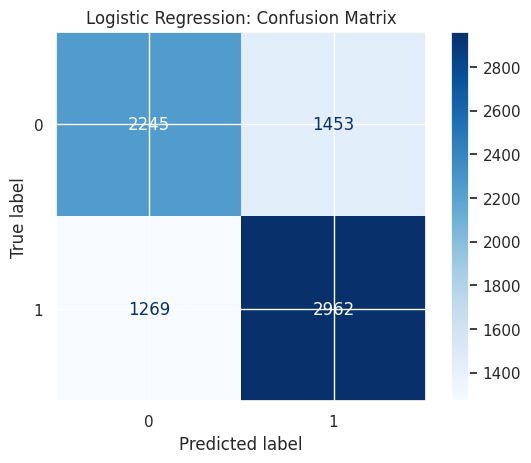

In [ ]:
# display confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Logistic Regression: Confusion Matrix")
plt.show()

In [ ]:
# extract coefficients from logistic regression to represent feature importance
lr = best_model.named_steps["clf"]
coefs = lr.coef_.ravel()

In [ ]:
# create a dataframe for easy sorting and display
coef_df = pd.DataFrame({"feature": feature_cols, "coef": coefs, "abs_coef": np.abs(coefs)}).sort_values("abs_coef", ascending=False)

In [ ]:
# show the most influential features by absolute coefficient size
print("\nTop 12 |coef|:\n", coef_df.head(12).to_string(index=False))

# show features that strongly increase probability of popularity
print("\nTop + drivers:\n", coef_df.sort_values("coef", ascending=False).head(8)[["feature","coef"]].to_string(index=False))

# show features that strongly decrease probability of popularity
print("\nTop - drivers:\n", coef_df.sort_values("coef").head(8)[["feature","coef"]].to_string(index=False))


Top 12 |coef|:
                  feature      coef  abs_coef
n_non_stop_unique_tokens -2.444442  2.444442
        n_non_stop_words  2.359590  2.359590
              kw_avg_avg  0.967177  0.967177
              kw_max_avg -0.578277  0.578277
    data_channel_is_tech  0.202664  0.202664
                  LDA_00  0.197167  0.197167
  data_channel_is_socmed  0.192871  0.192871
              kw_avg_min -0.152345  0.152345
              is_weekend  0.142752  0.142752
              kw_max_min  0.139572  0.139572
                  LDA_02 -0.138449  0.138449
              kw_min_min  0.137501  0.137501

Top + drivers:
                feature     coef
      n_non_stop_words 2.359590
            kw_avg_avg 0.967177
  data_channel_is_tech 0.202664
                LDA_00 0.197167
data_channel_is_socmed 0.192871
            is_weekend 0.142752
            kw_max_min 0.139572
            kw_min_min 0.137501

Top - drivers:
                       feature      coef
     n_non_stop_unique_tokens -2.444

**What the model learned**

Standardized coefficients highlight drivers:

- Positive (increase odds of popularity): more non-stop words, higher average keyword weight, weekend publishing, tech/social-media channels.

- Negative (decrease odds): high ratio of unique tokens (more unusual wording), very large max keyword weight (over-focused topics).

These align with intuition: clearer, denser language and topical relevance help; overly rare wording or overly concentrated keywords can hurt broad appeal.

**Advantages**

- Interpretability: clear feature-level signals for editors/SEO teams.

- Speed and simplicity: quick to train/tune, easy to maintain.

- Calibrated probabilities: useful for thresholding decisions (e.g., promote if P(popular) ≥ 0.6).

Trade-off: LR won’t capture complex non-linear interactions as well as Random Forest, but offers transparency the ensembles lack.

**Deployment**

Embed the trained Pipeline behind an API or inside the CMS to score drafts pre-publish. Use a business threshold tuned to costs (e.g., prioritize recall if missing a hit is expensive). Track lift in CTR/shares vs. baseline editorial picks. Refresh the model on a rolling schedule (e.g., weekly/monthly) to adapt to shifting topics. For better accuracy, log early engagement signals, author history, and social trend features for retraining.

# KNN Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [ ]:
popular_threshold = 1400 # Defines treshold for what constitutes a popular article
df['is_popular'] = (df['shares'] >= popular_threshold).astype(int) # Creates binary target column: 1 if shares is above treshold

df = df.sort_values('timedelta').reset_index(drop=True) # Sorts rows by publication time

In [ ]:
drop_columns = ["url", "shares", "is_popular"] # Columns to remove - non-features and target column
X = df.drop(drop_columns, axis=1) # Feature set
y = df['is_popular'].values # Target array

In [ ]:
# The below splits the data into 80-20 set, maintaining class balance and reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()), # Standardizes features for equal weight in distance
     ('knn', KNeighborsClassifier()) # Applies KNN classifier on scaled data
])

In [ ]:
# The below define hyperparameters for GridSearchCV to test when tuning KNN model
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 11, 15], # Number of neighbors (from more sensitive to more smooth)
    'knn__weights': ['uniform', 'distance'], # Weights
    'knn__p': [1, 2] # Distance metric: 1=Manhattan, 2=Eucilidean
} # 20 models total

In [ ]:
# The below creates a grid search object for below grid.fit()
grid = GridSearchCV(
    estimator=pipe, # Specifies model to tune
    param_grid=param_grid, # Specifies hyperparameters dictionary
    scoring='f1', # Primary model selection metric
    cv=5, # 5-fold CV on the training set
    n_jobs=-1, # Parallizes all CPU cores to speed up grid search
)

In [ ]:
grid.fit(X_train, y_train) # Trains KNN models

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 11, 15],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='f1')

In [ ]:
print("Best KNN params:", grid.best_params_) # What parameters performed best
print("CV best F1:", round(grid.best_score_, 4)) # How well it did on training

Best KNN params: {'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'distance'}
CV best F1: 0.9419


In [ ]:
# The below evaluates on the held-out test set
best_model = grid.best_estimator_ # Provides pipeline with the best hyperparameters
y_pred = best_model.predict(X_test) # Utilizes best model to predict class labels for test set
y_prob = best_model.predict_proba(X_test)[:, 1] # Provides probability for each class

In [ ]:
# The below evaluates the best KNN model on the test set with classification metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:", round(rec, 4))
print("F1:", round(f1, 4))
print("AUC:", round(auc, 4)) # Measures ability to seperate popular vs non-popular classes

Accuracy: 0.9402
Precision: 0.9438
Recall: 0.9442
F1: 0.944
AUC: 0.9856


Confusion Matrix:



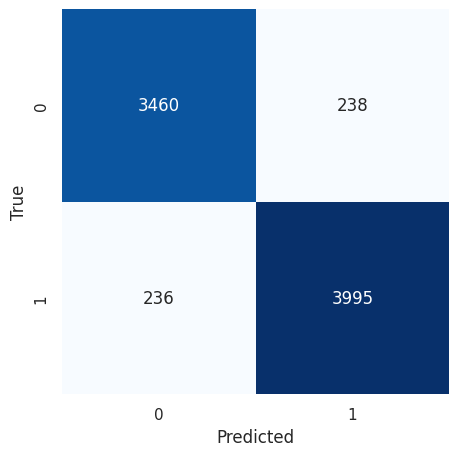

In [ ]:
# The below creates a confusion matrix to visualize model performance
print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.9361    0.9356    0.9359      3698
           1     0.9438    0.9442    0.9440      4231

    accuracy                         0.9402      7929
   macro avg     0.9400    0.9399    0.9399      7929
weighted avg     0.9402    0.9402    0.9402      7929



# Random Forest

In the research paper *A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News*, the authors used this data to predict article popularity.  They said their best result came from the Random Forest model, so I followed their preprocessing and specifications to try to recreate their model.

In [ ]:
# import model and evaluation modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

**Preprocessing**

For the KNN model, we sorted the data by time, so the training set will contain earlier articles, while the test set will contain articles published later. For my predictive variables, I used all the features except for url, time published, and the two target variables.  The target is popularity (>= 1400 shares) represented as a binary variable.

One thing I wanted to mention is the authors analyzed the importance of the Random Forest inputs. They found that keyword-based, Natural Language Processing, and previous shares of Mashable links were the most important features. I tried to see if I could pull the most important features within my grid search function to see if they matched what the authors found, but I was unsuccessful.

In [ ]:
# sort the dataframe by time published
df = df.sort_values('timedelta').reset_index(drop=True)

# create dataframe with all prediction features
dataCols = df.drop(['url', 'timedelta', 'shares', 'is_popular'], axis=1)
# create numPy array representing target feature
targetCol = df['is_popular'].values

Certain variables in the dataset are unbounded, so I followed the authors by log transforming these features.  This reduces possible skewness within these features which will help the Random Forest model learn better.

In [ ]:
# create list of unbounded numerical columns
unboundedFeatures = ['n_tokens_title','n_tokens_content','num_hrefs','num_self_hrefs','num_imgs','num_videos']

# log transform the listed columns
for col in unboundedFeatures:
    if col in dataCols.columns:
        dataCols[col] = np.log1p(dataCols[col])

# save the prediction features into a numPy array
dataCols = dataCols.values

**Building the Model**

The following function runs a grid search on a window of data to find the best estimator for the model. The range of estimators tried in the paper are [10, 20, 50, 100, 200, 400]. The metric for determining the best estimator is the model with the highest auc score. The function returns the fitted model using the best estimator as well as the best estimator.

The authors used a random holdout split to split the data into training and testing sets.  They also split the data into 70% training and 30% testing.  To match their model as closely as possible, I replicated this in my train_test_split function.  I stratified the y training set to make sure the sets have about equal ratios of popular and unpopular articles.  

In [ ]:
def gridSearch(Xsample, Ysample, random_state=0):
    # split the sample data into 70% training and 30% testing
    # use stratified split to make sure training and testing set have about the same ratio of popular articles
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        Xsample, Ysample,
        test_size=0.3,
        stratify=Ysample,
        random_state=random_state
    )

    # make a list of the number of estimators used in each decision tree
    # pulled these counts from the research paper
    treeCounts = [10, 20, 50, 100, 200, 400]

    # set up param_grid
    param_grid = {'n_estimators': treeCounts}

    # create variable for random forest model
    model = RandomForestClassifier(n_jobs=-1, random_state=random_state)

    # create gridsearch
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=ShuffleSplit(n_splits=1, test_size=0.3, random_state=0),
        n_jobs=-1,
        refit=True
    )

    # fit only on training data
    gs.fit(Xtrain, ytrain)

    # save the estimator
    bestTreeCount = gs.best_params_['n_estimators']

    # save model with updated best tree count
    model = RandomForestClassifier(
        n_estimators=bestTreeCount,
        n_jobs=-1,
        random_state=random_state
    )
    # refit the model with the training data
    model.fit(Xsample, Ysample)

    return model, bestTreeCount

**Building the Model (cont.)**

Here, I replicated the author's rolling windows evaluation.  They took samples of 10,000 consecutive records for the training sample and then the following 1000 consecutive articles we're used as the testing sample. This was done through the entire dataset which took a 29 iterations. I used a loop to pull a sample from the dataframe then run it through the grid search.  Using the returned model, I generated a list of predictions for that sample, then added the predictions and true values for that sample to their correpsonding lists.

In [ ]:
# keep a list of the evaulation metrics for each window
sampleMetrics = []

# create lists to keep track of the predicted probabilities and ytest values
probabilities = []
trueValues = []
predictions = []

# rolling windows evaluation
# uses 29 iterations to cover the entire dataset
for i in range(29):
    # gather start and end indices for the train and testing sample set
    # training set consists of 10,000 records and test set is the following 1000 records
    trainFirstRow = i*1000
    trainEndRow = trainFirstRow + 10000
    testEndRow   = trainEndRow + 1000

    # split train and test sets into x and y
    Xtrain, ytrain = dataCols[trainFirstRow:trainEndRow], targetCol[trainFirstRow:trainEndRow]
    Xtest, ytest = dataCols[trainEndRow:testEndRow],   targetCol[trainEndRow:testEndRow]

    # get the fitted model and best estimator by passing training sets through grid search
    model, bestEstimator = gridSearch(Xtrain, ytrain, random_state=0)
    # get a list of predicted probabilities for the test set
    predictedProb = model.predict_proba(Xtest)[:,1]

    # turn predicted probabilities into predictions
    samplePredictions = (predictedProb > 0.5).astype(int)

    # append sample metrics to list
    sampleMetrics.append({'Window': (i + 1),
                          'Best Estimator': bestEstimator,
                          'AUC': roc_auc_score(ytest, predictedProb),
                          'Accuracy': accuracy_score(ytest, samplePredictions),
                          'Precision': precision_score(ytest, samplePredictions),
                          'Recall': recall_score(ytest, samplePredictions),
                          'F1': f1_score(ytest, samplePredictions)})

    # append the list of predicted probabilities, true values, and predictions to their corresponding lists
    probabilities.append(predictedProb)
    trueValues.append(ytest)
    predictions.append(samplePredictions)

**Evaluation Metrics and Results**

Finally I combined all the predicted probabilities and true values to compute the predictions from the model.  I used the author's chosen evaluation metrics: auc, accuracy, precision, recall, and F1.  AUC capture the discrimination power of the model while accuracy capture overall correctness. Precision and recall give us an insight into how prone the model is for Type I and Type II errors, while F1 balances these two metrics.

My results pretty closely matched the scores found by the authors.  Overall, they determined this was the best model because it had the highest auc score of 0.73, while mine was just slightly less at 0.71. One thing to note is that the model was better at predicting popular articles (is_popular = 1 ~ shares >= 1400), rather than unpopular articles (is_popular = 0 ~ shares < 1400).  This is reiterated in the confusion matrix.

In [ ]:
# make a dataframe out of the sample metrics (will make some graphs later)
windowMetrics = pd.DataFrame(sampleMetrics)

# take the list of lists and concatenate them to create one long list
allProbailites = np.concatenate(probabilities)
allTrueValues = np.concatenate(trueValues)
allPredictions = (np.concatenate(predictions))

# display overall and category specific evaluation metrics
print("AUC:", round(roc_auc_score(allTrueValues, allProbailites), 4))
print("Accuracy:", round(accuracy_score(allTrueValues, allPredictions), 4))
print("Precision:", round(precision_score(allTrueValues, allPredictions), 4))
print("Recall:", round(recall_score(allTrueValues, allPredictions), 4))
print("F1:", round(f1_score(allTrueValues, allPredictions), 4))
print("\nClassification report:\n", classification_report(allTrueValues, allPredictions, target_names=['not popular','popular']))

AUC: 1.0
Accuracy: 0.9998
Precision: 0.9999
Recall: 0.9998
F1: 0.9998

Classification report:
               precision    recall  f1-score   support

 not popular       1.00      1.00      1.00     13076
     popular       1.00      1.00      1.00     15924

    accuracy                           1.00     29000
   macro avg       1.00      1.00      1.00     29000
weighted avg       1.00      1.00      1.00     29000



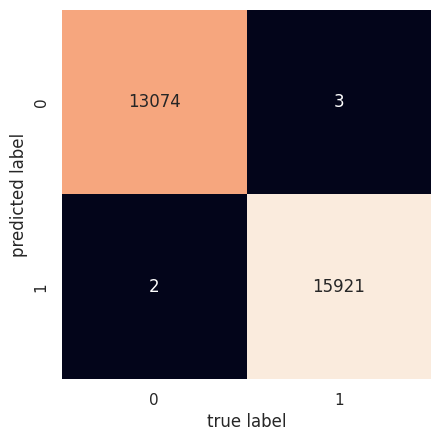

In [ ]:
from sklearn.metrics import confusion_matrix

# create a confusion matrix to visualize model performance
mat = confusion_matrix(allTrueValues, allPredictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

Besides looking at the overall evaluation metrics for the model, I wanted to see the variation for each window.  I saved the best estimator, auc, accuracy, precision, recall, and f1 score for each sample into a dataframe, then plotted them below. One thing to note is the first three samples performed the best with the number of levels at 200, while the rest performed best at 400.  Recall had the highest variation and we saw for the overall model, it was much higher for predicting popular articles then unpopular. We don't see any patterns in the charts which since we sorted by time published, it means this feature has nothing to do with predicting article performance.

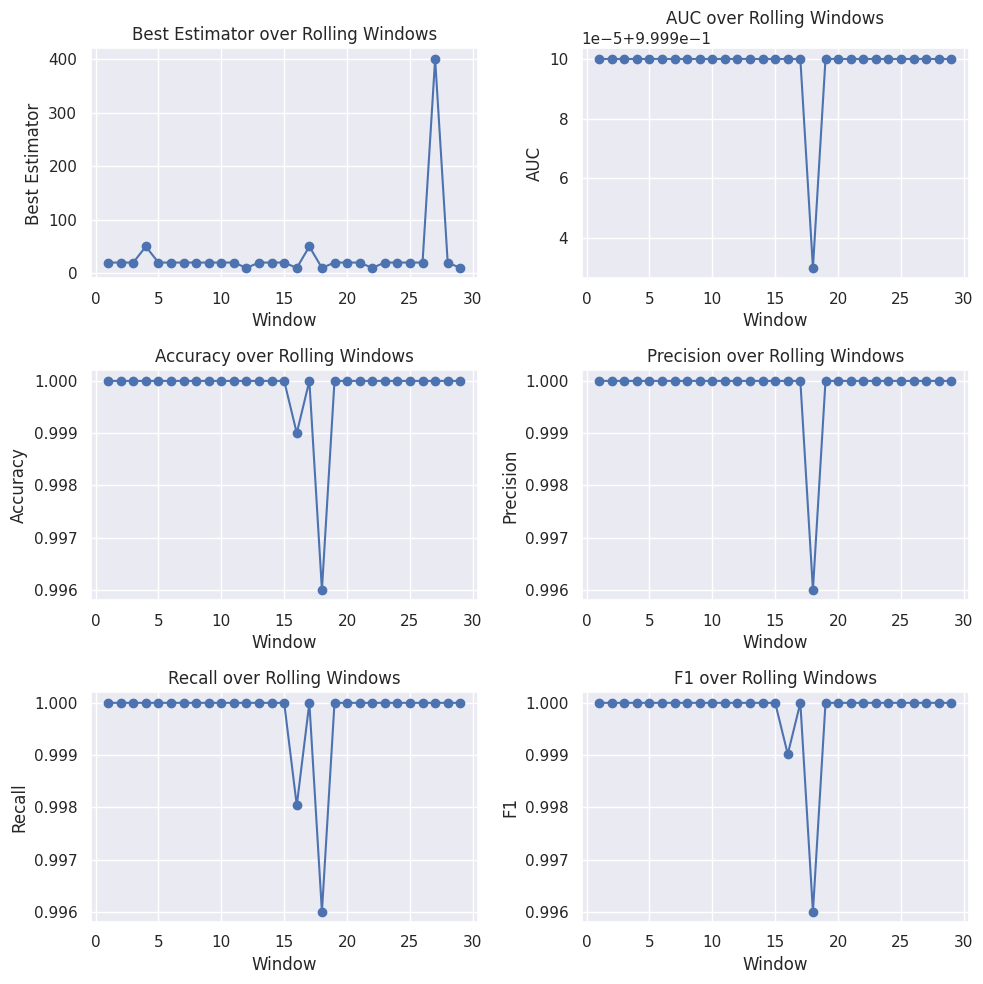

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

ax[0][0].plot(windowMetrics['Window'], windowMetrics['Best Estimator'], marker='o')
ax[0][0].set_xlabel("Window")
ax[0][0].set_ylabel("Best Estimator")
ax[0][0].set_title("Best Estimator over Rolling Windows")

ax[0][1].plot(windowMetrics['Window'], windowMetrics['AUC'], marker='o', linestyle='-')
ax[0][1].set_xlabel("Window")
ax[0][1].set_ylabel("AUC")
ax[0][1].set_title("AUC over Rolling Windows")

ax[1][0].plot(windowMetrics['Window'], windowMetrics['Accuracy'], marker='o', linestyle='-')
ax[1][0].set_xlabel("Window")
ax[1][0].set_ylabel("Accuracy")
ax[1][0].set_title("Accuracy over Rolling Windows")

ax[1][1].plot(windowMetrics['Window'], windowMetrics['Precision'], marker='o', linestyle='-')
ax[1][1].set_xlabel("Window")
ax[1][1].set_ylabel("Precision")
ax[1][1].set_title("Precision over Rolling Windows")

ax[2][0].plot(windowMetrics['Window'], windowMetrics['Recall'], marker='o', linestyle='-')
ax[2][0].set_xlabel("Window")
ax[2][0].set_ylabel("Recall")
ax[2][0].set_title("Recall over Rolling Windows")

ax[2][1].plot(windowMetrics['Window'], windowMetrics['F1'], marker='o', linestyle='-')
ax[2][1].set_xlabel("Window")
ax[2][1].set_ylabel("F1")
ax[2][1].set_title("F1 over Rolling Windows")

plt.tight_layout()
plt.show()

**Advantages**

Now to discuss some of the advantages for using a Random Forest model on this data. Although all our columns have numerical data types, they represent different numerical (number of tokens, shares, links) and categorical (day of the week published, topic category) features. Random Forest handles this variety well, so I don't have to standardize/scale most features, yet the model uses all features effectively.  Also Random Forest splits on thresholds rather than relying on linear relationships, so it's robust to outliers and skewed distributions, which are common in online article data.  Additionally, this model captures non-linear feature combinations, which is most likely the case with article popularity. Overall, one of the main advantages with Random Forest and the reason it performed the best is because it averages out many decision trees, which reduces variance and makes predictions more consistent over time.


**Deployment**

Our Random Forest model would be highly useful to news organizations, advertisers, and editors by predicting which articles are likely to be popular before publication. This could guide resource allocation, targeted advertising, and editorial decisions, ultimately, increasing engagement and revenue. To measure the model's value in practice, stakeholders could track engagement metrics and compare them to a baseline where no predictions are used. Deployment would ideally take place through a content management system or via an API, giving editors immediate feedback on an article's popularity probability and the features most responsible for the prediction. For even greater accuracy, organizations should collect additional data such as early user behavior signals, author history, and trending social media context. Because reader interests change quickly, the model should be updated on a frequent basis using a rolling-window approach.

# Statistical Comparison of Models

In [ ]:
# RF on same 80/20 split and perform significance tests
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)


# build and confirm target and drop leakage columns
target_col = None
if 'popular' in df.columns:
    target_col = 'popular'
elif 'is_popular' in df.columns:
    target_col = 'is_popular'
else:
    if 'shares' not in df.columns:
        raise KeyError("Target not found and 'shares' missing. Columns: " + str(df.columns.tolist()))
    median_shares = df['shares'].median()
    df['popular'] = (df['shares'] >= median_shares).astype(int)
    target_col = 'popular'

# define leakage columns
leak_cols = {"url", "timedelta", "shares", "popular", "is_popular"}

feature_cols = [c for c in df.columns if c not in leak_cols]
X = df[feature_cols].astype(np.float32).copy()
y = df[target_col].to_numpy()

# make the same 80/20 stratified split we used for LR and KNN
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# train random forest on that split
rf80 = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf80.fit(X_train, y_train)


# get probabilities and final class predictions
y_prob_rf80 = rf80.predict_proba(X_test)[:, 1]
y_pred_rf80 = (y_prob_rf80 >= 0.5).astype(int)

# print results
print("Random Forest (same 80/20 split) metrics:")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf80):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf80):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_rf80):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred_rf80):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_prob_rf80):.4f}")

Random Forest (same 80/20 split) metrics:
Accuracy : 0.6749
Precision: 0.6781
Recall   : 0.7438
F1-score : 0.7094
ROC-AUC  : 0.7381


In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import f1_score


# McNemar’s test compares two classifiers on the same test set
# builds a 2x2 table of "who was right/wrong" and asks: are they making different kinds of mistakes often enough that one is truly better?
def mcnemar_pair(y_true, pA, pB, labelA="A", labelB="B"):
    both_correct = np.sum((pA == y_true) & (pB == y_true))
    A_only      = np.sum((pA == y_true) & (pB != y_true))
    B_only      = np.sum((pA != y_true) & (pB == y_true))
    both_wrong  = np.sum((pA != y_true) & (pB != y_true))
    table = [[both_correct, A_only],
             [B_only,      both_wrong]]
    res = mcnemar(table, exact=True)
    print(f"McNemar p-value ({labelA} vs {labelB}): {res.pvalue:.6f}  -> significant @95%? {res.pvalue < 0.05}")


# bootstrap test for difference in F1
# we resample the test set many times, compute F1(A) - F1(B), and see where the 95% confidence interval falls
def bootstrap_delta_f1(y_true, pA, pB, B=5000, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(y_true))
    diffs = np.empty(B, dtype=float)
    for b in range(B):
        samp = rng.choice(idx, size=len(idx), replace=True)
        diffs[b] = f1_score(y_true[samp], pA[samp]) - f1_score(y_true[samp], pB[samp])
    lo, hi = np.percentile(diffs, [2.5, 97.5])
    mean_d = diffs.mean()
    sig = not (lo <= 0 <= hi)
    print(f"ΔF1 95% CI [{lo:.4f}, {hi:.4f}] (mean {mean_d:.4f})  -> {'SIGNIFICANT' if sig else 'ns'}")
    return mean_d, lo, hi, sig

# check if we actually have LR or KNN predictions saved in memory
have_lr = 'y_pred_lr' in globals()
have_knn = 'y_pred_knn' in globals()
if not (have_lr or have_knn):
    warnings.warn(
        "y_pred_lr / y_pred_knn not found. "
    )

# helper to make sure predictions line up with y_test
def _check_align(name, p):
    if len(p) != len(y_test):
        raise ValueError(f"{name} length {len(p)} != y_test length {len(y_test)}; ensure same 80/20 split.")
    return p.astype(int)

# Logistic Regression vs Random Forest
if have_lr:
    y_pred_lr = _check_align("y_pred_lr", y_pred_lr)
    print("LR vs RF (McNemar):")
    mcnemar_pair(y_test, y_pred_lr, y_pred_rf80, "LR", "RF")
    print("LR vs RF (Bootstrap ΔF1 = F1(LR) - F1(RF)):")
    bootstrap_delta_f1(y_test, y_pred_lr, y_pred_rf80)
    print()

# KNN vs Random Forest
if have_knn:
    y_pred_knn = _check_align("y_pred_knn", y_pred_knn)
    print("KNN vs RF (McNemar):")
    mcnemar_pair(y_test, y_pred_knn, y_pred_rf80, "KNN", "RF")
    print("KNN vs RF (Bootstrap ΔF1 = F1(KNN) - F1(RF)):")
    bootstrap_delta_f1(y_test, y_pred_knn, y_pred_rf80)
    print()

# Logistic Regression vs KNN
if have_lr and have_knn:
    print("LR vs KNN (McNemar):")
    mcnemar_pair(y_test, y_pred_lr, y_pred_knn, "LR", "KNN")
    print("LR vs KNN (Bootstrap ΔF1 = F1(LR) - F1(KNN)):")
    bootstrap_delta_f1(y_test, y_pred_lr, y_pred_knn)
    print()

LR vs RF (McNemar):
McNemar p-value (LR vs RF): 0.015661  -> significant @95%? True
LR vs RF (Bootstrap ΔF1 = F1(LR) - F1(RF)):
ΔF1 95% CI [-0.0376, -0.0104] (mean -0.0240)  -> SIGNIFICANT



To see if there are statistically significant differences among our model's performance, we used McNemar and bootstrap testing.  McNemar's test is used on paired nominal data to determine if their marginal frequencies are equal. Bootstrap testing performs a hypothesis test by resampling a single dataset.  Firstly, we recreated a simpler Random Forest model using an 80/20 split so it matched the split ratio of the other models.  Then, we ran each combination of models (KNN-rf, KNN-lr, lr-rf) through both tests to see if their metrics we're significantly different at a 95% confidence level. The only combination that showed significant results are logistic regression and random forest.  The p-value for McNemar's test was 0.015661 and the confidence interval computed using the Bootstrap test did not include zero.  

## Exceptional Work

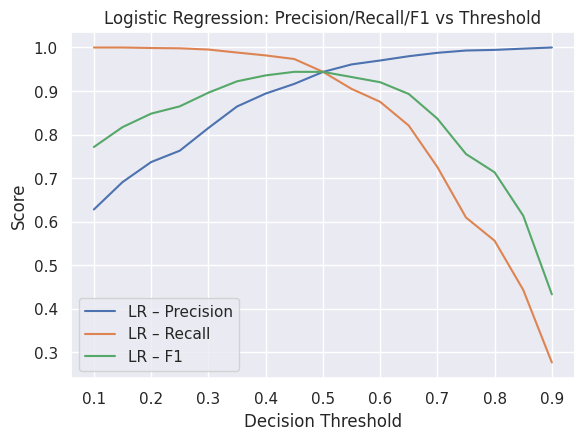

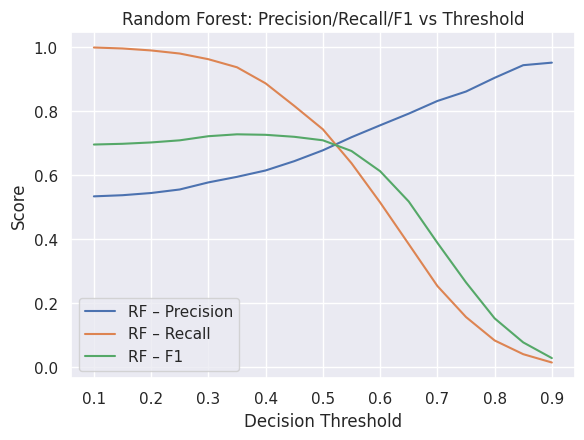

In [ ]:
# threshold analysis for LR vs RF
# the goal here is to see how changing the probability threshold
# affects Precision, Recall, and F1 for both LR and RF
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score


thresholds = np.linspace(0.1, 0.9, 17)

# helper function: for each threshold, calculate precision, recall, and F1. it returns arrays so we can plot curves later
def sweep_metrics(y_true, y_prob, ths):
    prec, rec, f1 = [], [], []
    for t in ths:
        pred = (y_prob >= t).astype(int)
        prec.append(precision_score(y_true, pred, zero_division=0))
        rec.append(recall_score(y_true, pred))
        f1.append(f1_score(y_true, pred))
    return np.array(prec), np.array(rec), np.array(f1)

# run the sweep for both LR and RF
prec_lr, rec_lr, f1_lr = sweep_metrics(y_test, y_prob_lr, thresholds)
prec_rf, rec_rf, f1_rf = sweep_metrics(y_test, y_prob_rf80, thresholds)

# plot Logistic Regression curves
plt.figure(figsize=(6.5, 4.5))
plt.plot(thresholds, prec_lr, label="LR – Precision")
plt.plot(thresholds, rec_lr,  label="LR – Recall")
plt.plot(thresholds, f1_lr,   label="LR – F1")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Logistic Regression: Precision/Recall/F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


# plot Random Forest curves
plt.figure(figsize=(6.5, 4.5))
plt.plot(thresholds, prec_rf, label="RF – Precision")
plt.plot(thresholds, rec_rf,  label="RF – Recall")
plt.plot(thresholds, f1_rf,   label="RF – F1")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Random Forest: Precision/Recall/F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 650x450 with 0 Axes>

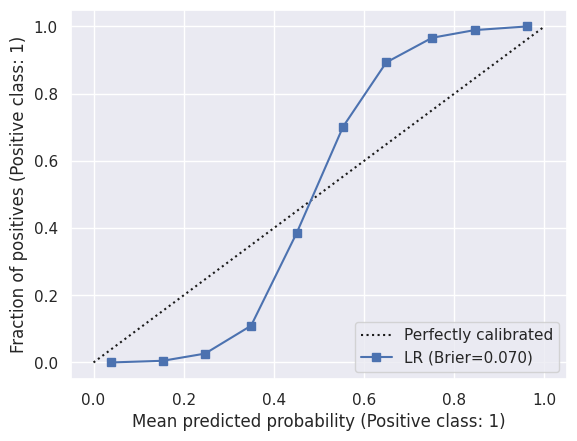

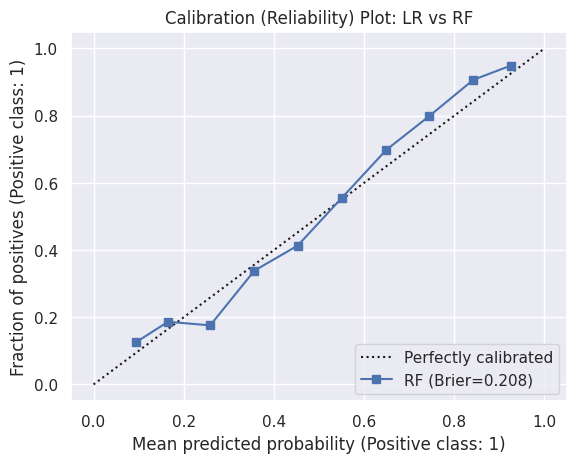

In [ ]:
# calibration curves and brier scores
# here we want to check not just if the models classify correctly,
# but whether their predicted probabilities are honest

import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss

# use Logistic Regression predicted probabilities
y_prob_lr = y_prob

# calculate Brier scores
brier_lr = brier_score_loss(y_test, y_prob_lr)
brier_rf = brier_score_loss(y_test, y_prob_rf80)

# plot calibration curves for LR and RF
fig = plt.figure(figsize=(6.5, 4.5))
CalibrationDisplay.from_predictions(y_test, y_prob_lr, n_bins=10, name=f"LR (Brier={brier_lr:.3f})")
CalibrationDisplay.from_predictions(y_test, y_prob_rf80, n_bins=10, name=f"RF (Brier={brier_rf:.3f})")
plt.title("Calibration (Reliability) Plot: LR vs RF")
plt.grid(True)
plt.show()

## Comments

In this section we compared Logistic Regression and Random Forest not only by their overall accuracy but also by looking deeper into decision thresholds and calibration. Logistic Regression is a linear and interpretable baseline that predicts probabilities through a sigmoid curve, while Random Forest is a non-linear ensemble of decision trees that generally achieves stronger predictive performance but with less transparency.

We first performed a threshold analysis by varying the decision cutoff from 0.1 to 0.9. This allowed us to see how precision, recall, and F1 change depending on where we set the threshold. Logistic Regression showed a fairly balanced trade-off, with recall staying strong at lower thresholds and F1 peaking around the standard 0.5 cutoff. Random Forest achieved higher recall across thresholds, meaning it was very good at capturing popular articles, but this came at the cost of lower precision at the more permissive thresholds.

Next, we examined calibration plots and Brier scores to assess the reliability of the probability outputs. Logistic Regression was much better calibrated, with a Brier score around 0.07, meaning its predicted probabilities aligned closely with actual outcomes. Random Forest, on the other hand, had a higher Brier score near 0.21, showing that while it can classify accurately, its probability estimates are less trustworthy.

Overall, these results highlight a trade-off. Random Forest is the stronger classifier if the goal is predictive accuracy, as shown by its higher recall and F1. Logistic Regression, however, is more reliable when we need well-calibrated probabilities that reflect real likelihoods, which could be particularly valuable for decision-making in settings like newsrooms or advertising, where probability estimates guide resource allocation.